# TP1 - Analyzing New York City Taxi Data


## Data Cleaning and Processing   

In [5]:
# Cell 0: imports and Spark session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import json
from shapely.geometry import shape, Point
from pyspark.sql.types import StringType, DoubleType, LongType, IntegerType
import math
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

spark = SparkSession.builder \
    .appName("NYC Taxi Analysis - TP1") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

In [3]:
# Cell 1: file paths (adjust for your container)
taxi_csv_path = "../data/Sample NYC Data.csv"   # <-- adjust path inside the container
borough_geojson_path = "../data/nyc-boroughs.geojson.json"  # <-- adjust
output_dir = "../data/output_tp1"   # where results will be written

os.makedirs(output_dir, exist_ok=True)

print(os.path.exists(taxi_csv_path), os.path.exists(borough_geojson_path), os.path.exists(output_dir))

False False True


In [7]:
# Cell 2: load CSV (select only needed columns). adapt column names if sample differs.
df_raw = spark.read.option("header", "true").option("inferSchema", "true").csv(taxi_csv_path)

cols_needed = [
    "hack_license",
    "pickup_datetime",
    "dropoff_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude"
]

# Check present columns
present = [c for c in cols_needed if c in df_raw.columns]
missing = [c for c in cols_needed if c not in df_raw.columns]
if missing:
    print("WARNING: missing columns (update names to match your CSV):", missing)

df = df_raw.select(*present).na.drop(subset=["hack_license","pickup_datetime","dropoff_datetime"])
df = df.withColumnRenamed("hack_license","taxi_id")  # use taxi_id as unique driver/car id
df.show(5)

+--------------------+---------------+----------------+----------------+---------------+-----------------+----------------+
|             taxi_id|pickup_datetime|dropoff_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+---------------+----------------+----------------+---------------+-----------------+----------------+
|BA96DE419E711691B...| 01-01-13 15:11|  01-01-13 15:18|      -73.978165|      40.757977|       -73.989838|       40.751171|
|9FD8F69F0804BDB55...| 06-01-13 00:18|  06-01-13 00:22|      -74.006683|      40.731781|       -73.994499|        40.75066|
|9FD8F69F0804BDB55...| 05-01-13 18:49|  05-01-13 18:54|      -74.004707|       40.73777|       -74.009834|       40.726002|
|51EE87E3205C985EF...| 07-01-13 23:54|  07-01-13 23:58|      -73.974602|      40.759945|       -73.984734|       40.759388|
|51EE87E3205C985EF...| 07-01-13 23:25|  07-01-13 23:34|       -73.97625|      40.748528|       -74.002586|       40.747868|
+-------

In [8]:
# Cell 3: load GeoJSON, build list of (borough_name, polygon) sorted by borough code and polygon area descending
with open(borough_geojson_path, "r", encoding="utf-8") as f:
    gj = json.load(f)

features = gj.get("features", [])
polys = []
for feat in features:
    props = feat.get("properties", {})
    geom = feat.get("geometry")
    bcode = props.get("boroughCode", None)   # if available
    bname = props.get("borough", props.get("boro_name", props.get("name", "UNKNOWN")))
    shapely_poly = shape(geom)
    area = shapely_poly.area
    polys.append({"borough": bname, "code": bcode if bcode is not None else 999, "area": area, "poly": shapely_poly})

# sort: boroughCode asc (manhattan=1) and within that area desc; but easier: sort by (code, -area)
polys_sorted = sorted(polys, key=lambda x: (x["code"], -x["area"]))

# Build a smaller broadcastable structure: list of tuples (borough, wkt) or keep shapely polygons directly.
# We'll broadcast a list of (borough, polygon) where polygon is shapely geometry
broad_list = [(p["borough"], p["poly"]) for p in polys_sorted]

bc_polys = spark.sparkContext.broadcast(broad_list)

print(bc_polys.value[:5])  # show first 5 borough polygons
print("Number of borough polygons broadcasted:", len(bc_polys.value))

[('Manhattan', <POLYGON ((-73.926 40.878, -73.926 40.877, -73.926 40.877, -73.926 40.877, -...>), ('Manhattan', <POLYGON ((-73.921 40.801, -73.92 40.799, -73.917 40.798, -73.915 40.797, -7...>), ('Manhattan', <POLYGON ((-74.017 40.693, -74.015 40.693, -74.015 40.693, -74.015 40.693, -...>), ('Manhattan', <POLYGON ((-73.942 40.769, -73.943 40.768, -73.949 40.761, -73.952 40.758, -...>), ('Manhattan', <POLYGON ((-73.907 40.876, -73.908 40.873, -73.908 40.873, -73.909 40.872, -...>)]
Number of borough polygons broadcasted: 104


In [11]:
# Cell 4: define UDF to map lon/lat to borough. Returns 'UNKNOWN' if not found or coords invalid.
def lonlat_to_borough(lon, lat):
    try:
        if lon is None or lat is None:
            return "UNKNOWN"
        # some datasets use strings; cast
        lon_f = float(lon)
        lat_f = float(lat)
    except Exception:
        return "UNKNOWN"
    pt = Point(lon_f, lat_f)
    for borough, poly in bc_polys.value:
        # shapely contains
        if poly.contains(pt) or poly.touches(pt):
            return borough
    return "UNKNOWN"

from pyspark.sql.functions import udf
udf_lonlat_to_borough = udf(lonlat_to_borough, StringType())

print(udf_lonlat_to_borough)

<function lonlat_to_borough at 0x7e0369c62f20>


In [13]:
# Cell 5: enrich dataframe with boroughs and timestamps (unix)
# create pickup_ts and dropoff_ts in seconds from epoch

df2 = df \
    .withColumn(
        "pickup_ts",
        F.unix_timestamp("pickup_datetime", "dd-MM-yy HH:mm")
    ) \
    .withColumn(
        "dropoff_ts",
        F.unix_timestamp("dropoff_datetime", "dd-MM-yy HH:mm")
    ) \
    .withColumn(
        "pickup_borough",
        udf_lonlat_to_borough(F.col("pickup_longitude"), F.col("pickup_latitude"))
    ) \
    .withColumn(
        "dropoff_borough",
        udf_lonlat_to_borough(F.col("dropoff_longitude"), F.col("dropoff_latitude"))
    )

# compute duration_seconds
df2 = df2.withColumn("duration_s", F.col("dropoff_ts") - F.col("pickup_ts"))

# verify
df2.select("pickup_datetime","dropoff_datetime","pickup_ts","dropoff_ts","duration_s","pickup_borough","dropoff_borough").show(5)

+---------------+----------------+----------+----------+----------+--------------+---------------+
|pickup_datetime|dropoff_datetime| pickup_ts|dropoff_ts|duration_s|pickup_borough|dropoff_borough|
+---------------+----------------+----------+----------+----------+--------------+---------------+
| 01-01-13 15:11|  01-01-13 15:18|1357053060|1357053480|       420|     Manhattan|      Manhattan|
| 06-01-13 00:18|  06-01-13 00:22|1357431480|1357431720|       240|     Manhattan|      Manhattan|
| 05-01-13 18:49|  05-01-13 18:54|1357411740|1357412040|       300|     Manhattan|      Manhattan|
| 07-01-13 23:54|  07-01-13 23:58|1357602840|1357603080|       240|     Manhattan|      Manhattan|
| 07-01-13 23:25|  07-01-13 23:34|1357601100|1357601640|       540|     Manhattan|      Manhattan|
+---------------+----------------+----------+----------+----------+--------------+---------------+
only showing top 5 rows



In [14]:
# Cell 6: Filter - remove negative durations and durations greater than 4 hours (14400s)
MAX_DURATION_S = 4 * 3600
df_clean = df2.filter((F.col("duration_s") >= 0) & (F.col("duration_s") <= MAX_DURATION_S))
# optional: drop rows with UNKNOWN coords, but we keep UNKNOWN for counting if needed
print("Total records after cleaning:", df_clean.count())

Total records after cleaning: 99999


In [15]:
# Cell 7: Utilization computation per taxi
# For each taxi, sort by pickup_ts and compute previous dropoff_ts (lag)
w = Window.partitionBy("taxi_id").orderBy("pickup_ts")
df_sessions = df_clean \
    .withColumn("prev_dropoff_ts", F.lag("dropoff_ts").over(w)) \
    .withColumn("idle_s_raw", F.col("pickup_ts") - F.col("prev_dropoff_ts"))

# Consider idle only if prev exists and idle >0 and <= 4h (we ignore gaps > 4h as new session)
df_sessions = df_sessions.withColumn(
    "idle_s",
    F.when((F.col("prev_dropoff_ts").isNotNull()) & (F.col("idle_s_raw") > 0) & (F.col("idle_s_raw") <= MAX_DURATION_S),
           F.col("idle_s_raw")).otherwise(F.lit(0))
)

# sum per taxi: occupied_time (sum duration_s) and total_idle (sum idle_s)
per_taxi = df_sessions.groupBy("taxi_id").agg(
    F.sum("duration_s").alias("occupied_s"),
    F.sum("idle_s").alias("idle_s"),
    F.count("*").alias("trips_count")
)

# compute utilization: occupied / (occupied + idle). If both zero (shouldn't happen), set to null or 0.
per_taxi = per_taxi.withColumn(
    "utilization",
    F.when((F.col("occupied_s") + F.col("idle_s")) > 0,
           F.col("occupied_s") / (F.col("occupied_s") + F.col("idle_s"))).otherwise(F.lit(None))
)

per_taxi.cache()
per_taxi.select("taxi_id","trips_count","occupied_s","idle_s","utilization").show(10, truncate=False)

+--------------------------------+-----------+----------+------+-------------------+
|taxi_id                         |trips_count|occupied_s|idle_s|utilization        |
+--------------------------------+-----------+----------+------+-------------------+
|001C8AAB90AEE49F36FCAA7B4136C81A|5          |2820      |12960 |0.17870722433460076|
|0025133AD810DBE80D35FCA8BF0BCA1F|2          |1440      |2400  |0.375              |
|002C093A2CB9FD40C8C54AB5D158FC47|17         |12600     |15300 |0.45161290322580644|
|00374328FBA75FBFCA7522671250F573|1          |960       |0     |1.0                |
|00447A6197DBB329FBF764139ACA6EC4|5          |6420      |13440 |0.32326283987915405|
|0046F1E91AA13DEDE4F6EE775C6293AB|19         |11580     |9960  |0.5376044568245125 |
|00567B1CBFD51DDFAC73359B09238922|21         |11520     |10080 |0.5333333333333333 |
|0057CCB5BA8D29E343B3D6D275AB22D3|1          |300       |0     |1.0                |
|006114F940CB87B3ABDCE9BF6DF6FCC4|25         |16380     |24000 |0

In [16]:
# Cell 8: Save per_taxi results
per_taxi_output = output_dir + "/per_taxi_utilization"
per_taxi.coalesce(1).write.mode("overwrite").option("header","true").csv(per_taxi_output)
print("Saved per-taxi utilization to:", per_taxi_output)

Saved per-taxi utilization to: ../data/output_tp1/per_taxi_utilization


In [17]:
# Cell 9: Average time to next fare per destination borough (dropoff borough)
# For each taxi ordered by pickup_ts compute lead(pickup_ts) to know next pickup; delta = next_pickup_ts - dropoff_ts (time to next fare)
df_next = df_clean.withColumn("next_pickup_ts", F.lead("pickup_ts").over(w)) \
    .withColumn("time_to_next_s_raw", F.col("next_pickup_ts") - F.col("dropoff_ts"))

# consider only positive and <= 4h (session continuation)
df_next = df_next.withColumn(
    "time_to_next_s",
    F.when((F.col("time_to_next_s_raw") > 0) & (F.col("time_to_next_s_raw") <= MAX_DURATION_S), F.col("time_to_next_s_raw")).otherwise(F.lit(None))
)

# Group by dropoff_borough and compute average
avg_time_to_next = df_next.filter(F.col("time_to_next_s").isNotNull()).groupBy("dropoff_borough").agg(
    F.count("*").alias("count_samples"),
    F.avg("time_to_next_s").alias("avg_time_to_next_s"),
    F.expr("percentile_approx(time_to_next_s, 0.5)").alias("median_time_to_next_s")
).orderBy("dropoff_borough")

avg_time_to_next.show(truncate=False)
avg_time_to_next.coalesce(1).write.mode("overwrite").option("header","true").csv(output_dir + "/avg_time_to_next_per_dropoff_borough")

+---------------+-------------+------------------+---------------------+
|dropoff_borough|count_samples|avg_time_to_next_s|median_time_to_next_s|
+---------------+-------------+------------------+---------------------+
|Bronx          |303          |2223.5643564356437|1560                 |
|Brooklyn       |2593         |2086.903200925569 |1380                 |
|Manhattan      |78228        |912.8708390857494 |420                  |
|Queens         |4157         |2676.7187875872023|2040                 |
|Staten Island  |8            |4710.0            |3960                 |
|UNKNOWN        |1943         |1498.7339166237778|720                  |
+---------------+-------------+------------------+---------------------+



In [18]:
# Cell 10: Trips that started and ended within the same borough
same_borough = df_clean.filter(
    (F.col("pickup_borough").isNotNull()) & (F.col("dropoff_borough").isNotNull()) &
    (F.col("pickup_borough") == F.col("dropoff_borough")) & (F.col("pickup_borough") != "UNKNOWN")
).groupBy("pickup_borough").agg(F.count("*").alias("num_trips_same_borough")).orderBy("num_trips_same_borough", ascending=False)

same_borough.show(truncate=False)
same_borough.coalesce(1).write.mode("overwrite").option("header","true").csv(output_dir + "/trips_same_borough")

+--------------+----------------------+
|pickup_borough|num_trips_same_borough|
+--------------+----------------------+
|Manhattan     |83561                 |
|Queens        |1396                  |
|Brooklyn      |1065                  |
|Bronx         |51                    |
|Staten Island |1                     |
+--------------+----------------------+



In [19]:
# Cell 11: Trips that started in one borough and ended in another
cross_borough = df_clean.filter(
    (F.col("pickup_borough") != F.col("dropoff_borough")) &
    (F.col("pickup_borough") != "UNKNOWN") &
    (F.col("dropoff_borough") != "UNKNOWN")
).groupBy("pickup_borough", "dropoff_borough").agg(F.count("*").alias("num_trips")).orderBy(F.desc("num_trips"))

cross_borough.show(50, truncate=False)
cross_borough.coalesce(1).write.mode("overwrite").option("header","true").csv(output_dir + "/trips_cross_borough")

+--------------+---------------+---------+
|pickup_borough|dropoff_borough|num_trips|
+--------------+---------------+---------+
|Manhattan     |Queens         |3943     |
|Queens        |Manhattan      |3698     |
|Manhattan     |Brooklyn       |1923     |
|Brooklyn      |Manhattan      |774      |
|Queens        |Brooklyn       |597      |
|Manhattan     |Bronx          |244      |
|Brooklyn      |Queens         |115      |
|Queens        |Bronx          |100      |
|Bronx         |Manhattan      |25       |
|Manhattan     |Staten Island  |9        |
|Bronx         |Queens         |2        |
|Queens        |Staten Island  |2        |
|Staten Island |Queens         |1        |
+--------------+---------------+---------+



In [20]:
# Cell 12: Basic summaries and write to one summary CSV
summary = {
    "total_trips_cleaned": df_clean.count(),
    "total_unique_taxis": per_taxi.count(),
    "avg_trips_per_taxi": df_clean.count() / max(per_taxi.count(), 1)
}
import json, os
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Summary:", summary)

Summary: {'total_trips_cleaned': 99999, 'total_unique_taxis': 9990, 'avg_trips_per_taxi': 10.00990990990991}


In [21]:
# Cell 13: OPTIONAL: show some example trips (head) to include in report
df_clean.select("taxi_id","pickup_datetime","dropoff_datetime","pickup_borough","dropoff_borough","duration_s").show(20, truncate=False)

+--------------------------------+---------------+----------------+--------------+---------------+----------+
|taxi_id                         |pickup_datetime|dropoff_datetime|pickup_borough|dropoff_borough|duration_s|
+--------------------------------+---------------+----------------+--------------+---------------+----------+
|BA96DE419E711691B9445D6A6307C170|01-01-13 15:11 |01-01-13 15:18  |Manhattan     |Manhattan      |420       |
|9FD8F69F0804BDB5549F40E9DA1BE472|06-01-13 00:18 |06-01-13 00:22  |Manhattan     |Manhattan      |240       |
|9FD8F69F0804BDB5549F40E9DA1BE472|05-01-13 18:49 |05-01-13 18:54  |Manhattan     |Manhattan      |300       |
|51EE87E3205C985EF8431D850C786310|07-01-13 23:54 |07-01-13 23:58  |Manhattan     |Manhattan      |240       |
|51EE87E3205C985EF8431D850C786310|07-01-13 23:25 |07-01-13 23:34  |Manhattan     |Manhattan      |540       |
|598CCE5B9C1918568DEE71F43CF26CD2|07-01-13 15:27 |07-01-13 15:38  |Manhattan     |Manhattan      |660       |
|513189AD7

## Visualizations  

In [ ]:
#Load saved results (replace paths if needed)
utilization_df = spark.read.csv(f"{output_dir}/per_taxi_utilization", header=True, inferSchema=True).toPandas()
waiting_df = spark.read.csv(f"{output_dir}/avg_time_to_next_per_dropoff_borough", header=True, inferSchema=True).toPandas()
same_borough_df = spark.read.csv(f"{output_dir}/trips_same_borough", header=True, inferSchema=True).toPandas()
cross_borough_df = spark.read.csv(f"{output_dir}/trips_cross_borough", header=True, inferSchema=True).toPandas()


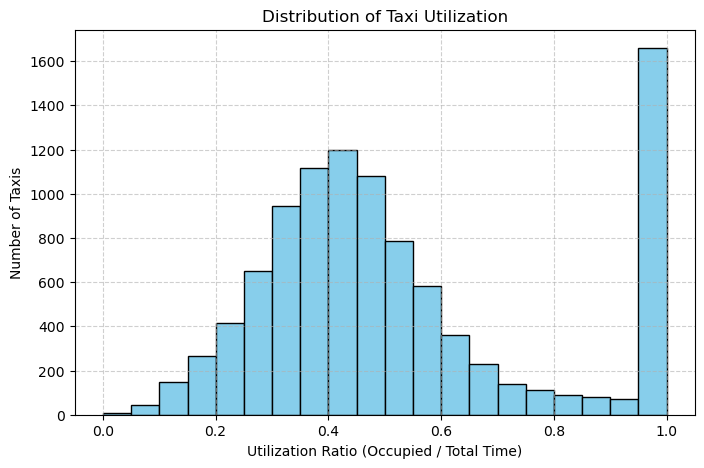

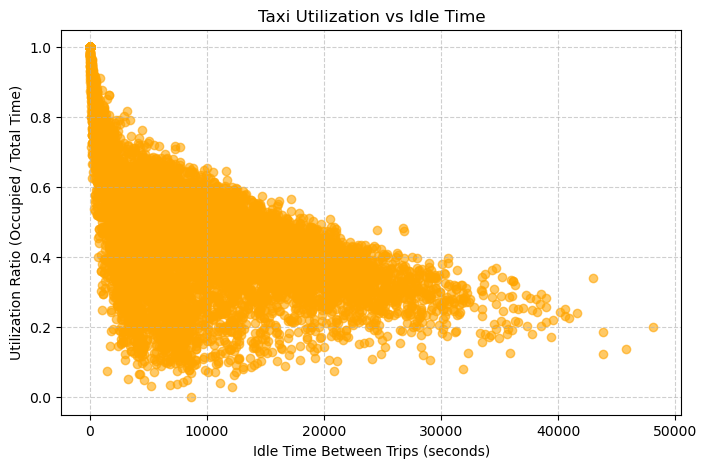

In [30]:
# ----------------------------------------------------------
# Utilization distribution histogram
# ----------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(utilization_df["utilization"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Taxi Utilization")
plt.xlabel("Utilization Ratio (Occupied / Total Time)")
plt.ylabel("Number of Taxis")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------------------
# Utilization vs Idle Time (scatter)
# ----------------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(utilization_df["idle_s"], utilization_df["utilization"], alpha=0.6, color='orange')
plt.title("Taxi Utilization vs Idle Time")
plt.xlabel("Idle Time Between Trips (seconds)")
plt.ylabel("Utilization Ratio (Occupied / Total Time)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Columns in waiting_df: ['dropoff_borough', 'count_samples', 'avg_time_to_next_s', 'median_time_to_next_s']


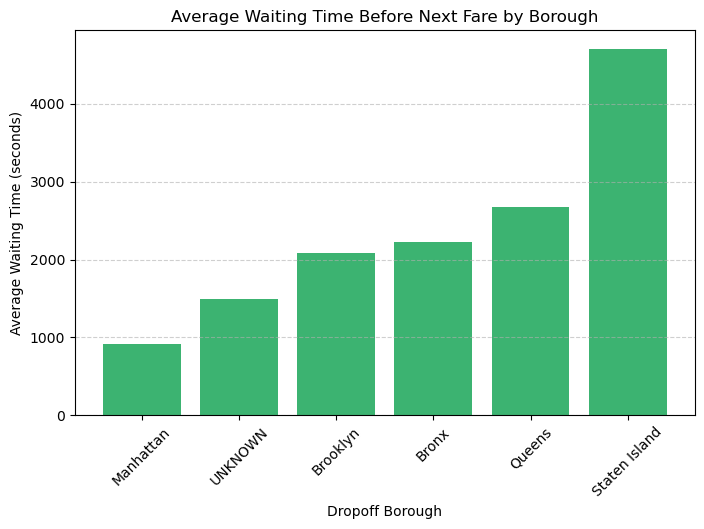

In [23]:
# ----------------------------------------------------------
# Average Waiting Time by Borough (bar)
# ----------------------------------------------------------
print("Columns in waiting_df:", list(waiting_df.columns))  # check real column names first

# Normalize column names (lowercase)
waiting_df.columns = [c.lower() for c in waiting_df.columns]

# Detect column for average time
time_col = None
for c in waiting_df.columns:
    if "avg" in c and "time" in c:
        time_col = c
        break

if time_col is None:
    raise KeyError("Could not find average time column in waiting_df!")

# Detect borough column
borough_col = None
for c in waiting_df.columns:
    if "boro" in c:
        borough_col = c
        break

if borough_col is None:
    raise KeyError("Could not find borough column in waiting_df!")

# Now plot safely
waiting_df = waiting_df.sort_values(time_col, ascending=True)
plt.figure(figsize=(8,5))
plt.bar(waiting_df[borough_col], waiting_df[time_col], color='mediumseagreen')
plt.title("Average Waiting Time Before Next Fare by Borough")
plt.xlabel("Dropoff Borough")
plt.ylabel("Average Waiting Time (seconds)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Loaded Same-Borough Trips:
  pickup_borough  num_trips_same_borough
0      Manhattan                   83561
1         Queens                    1396
2       Brooklyn                    1065
3          Bronx                      51
4  Staten Island                       1


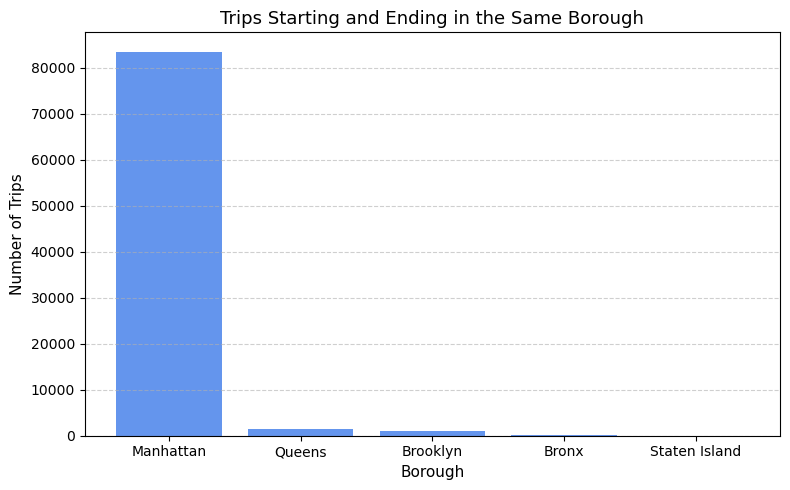

In [26]:
# Load the same-borough trip results from the saved CSV
same_df = pd.read_csv("../data/output_tp1/trips_same_borough/part-00000-5325a43b-fa14-4809-9629-923c9c64f545-c000.csv")

print("Loaded Same-Borough Trips:")
print(same_df.head())

# Normalize column names to lowercase
same_df.columns = [c.lower() for c in same_df.columns]

# Detect column names automatically
boro_col = next((c for c in same_df.columns if "boro" in c), same_df.columns[0])
count_col = next((c for c in same_df.columns if "count" in c or "num" in c), same_df.columns[-1])

# Sort by trip count
same_df = same_df.sort_values(count_col, ascending=False)

# ---- Visualization ----
plt.figure(figsize=(8,5))
plt.bar(same_df[boro_col], same_df[count_col], color="cornflowerblue")
plt.title("Trips Starting and Ending in the Same Borough", fontsize=13)
plt.xlabel("Borough", fontsize=11)
plt.ylabel("Number of Trips", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Loaded Cross-Borough Trips:
  pickup_borough dropoff_borough  num_trips
0      Manhattan          Queens       3943
1         Queens       Manhattan       3698
2      Manhattan        Brooklyn       1923
3       Brooklyn       Manhattan        774
4         Queens        Brooklyn        597


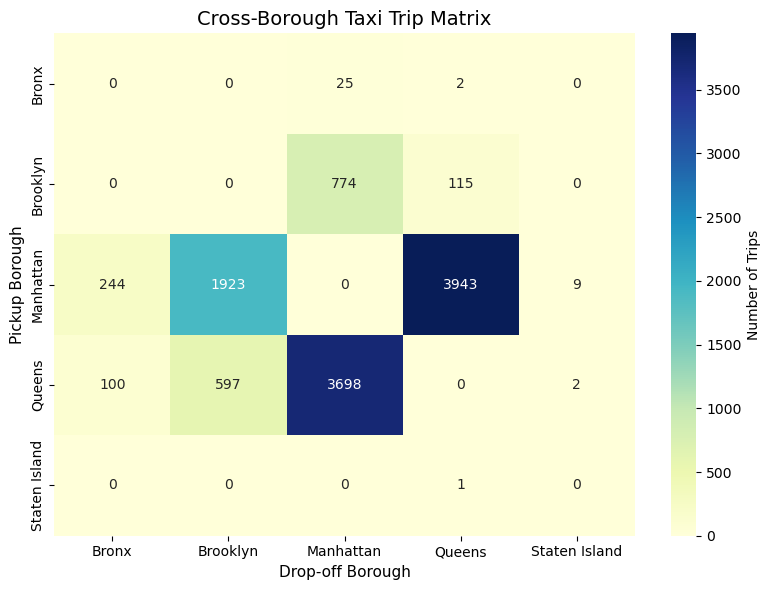

In [28]:
# ---- Load the cross-borough trips CSV ----
# (your PySpark notebook saved it in ../data/output_tp1/trips_cross_borough)
csv_path = glob.glob("../data/output_tp1/trips_cross_borough/part-00000*.csv")[0]
cross_df = pd.read_csv(csv_path)

print("Loaded Cross-Borough Trips:")
print(cross_df.head())

# ---- Normalize column names ----
cross_df.columns = [c.lower() for c in cross_df.columns]

# ---- Detect relevant columns automatically ----
pickup_col = next((c for c in cross_df.columns if "pickup" in c), None)
dropoff_col = next((c for c in cross_df.columns if "dropoff" in c), None)
count_col = next((c for c in cross_df.columns if "num" in c or "count" in c), None)

# ---- Pivot table to make matrix ----
pivot_df = cross_df.pivot_table(index=pickup_col, columns=dropoff_col, values=count_col, aggfunc="sum", fill_value=0)

# ---- Heatmap Visualization ----
plt.figure(figsize=(8,6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Number of Trips'})
plt.title("Cross-Borough Taxi Trip Matrix", fontsize=14)
plt.xlabel("Drop-off Borough", fontsize=11)
plt.ylabel("Pickup Borough", fontsize=11)
plt.tight_layout()
plt.show()